# Comparing the fidelity of different decompositions methods
- **Authors:** Andrea Barletta, Yanlong Wang
- **Abstract:** In our project we will compare the fidelity of three different architectures for universal multiport interferometers, used to perform any unitary or linear transformation. In particular we will focus on comparing the traditional Reck and Clements architectures with a Universal Generalized Mach–Zehnder Interferometer (UGMZI) architecture inired by the work of P. Dita 

## Global stuff

### Imports

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from circuit.interferometer import interferometer as itf
from circuit.beam_splitter import beam_splitter as bs

### Utils

In [55]:
def random_unitary(N):
    X = np.zeros([N, N], dtype=np.complex128)
    for ii in range(N):
        for jj in range(N):
            X[ii, jj] = (np.random.normal() + 1j * np.random.normal()) / np.sqrt(2)

    q, r = np.linalg.qr(X)
    r = np.diag(np.divide(np.diag(r), abs(np.diag(r))))
    U = np.matmul(q, r)

    return U

def my_atan(x1, x2):
    if x2 != 0:
        return np.arctan(abs(x1/x2))
    else:
        return np.pi/2

def my_angle(x1, x2):
    if x2 != 0:
        return np.angle(x1/x2)
    else:
        return 0


### Matrix representation of MZI

For the MZI blocks, we will use the configuration with 2 phase shifters and 2 couplers, organized as follows

<p align="center">
    <img src="mzi.svg" width="70%" />
</p>

Which yields the following matrix for the MZI transfer function

$$
    T_{MZI} =
    \begin{bmatrix} 
        e^{j\varphi}\cos(\theta) & -\sin(\theta) \\
        e^{j\varphi}\sin(\theta) & \cos(\theta)
    \end{bmatrix}
$$

It's crucial to notice that this form appears in the Givens Rotation, and it will be the central point of all the decomposition methods

## Reck's Method
**References**

Reck, Michael, et al. "Experimental realization of any discrete unitary operator." Physical review letters 73.1 (1994): 58.    

Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="reck.png" width="50%"/>
</p>

We will also add a line of phase shifters at the end to achieve aritrary phase at the output (note that the values of the phase shifters are implicitly computed by the decomposition method)

In [56]:
def decompose_reck(U):    
    """Decompose a unitary matrix into a sequence of beamsplitters."""
    I = itf()
    N = int(np.sqrt(U.size))
    for ii in range(N-1):
        for jj in range(N-1-ii):
            modes = [N - jj - 1, N - jj]
            theta = my_atan(U[ii, N - 1 - jj], U[ii, N - 2 - jj])
            phi = -my_angle(-U[ii, N - 1 - jj], U[ii, N - 2 - jj])
            invT = np.eye(N, dtype=np.complex128)
            invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
            invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
            invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
            invT[modes[1]-1, modes[1]-1] = np.cos(theta)
            U = np.matmul(U, invT)
            I.BS_list.append(bs(modes[0], modes[1], theta, phi))
    phases = np.diag(U)
    I.output_phases = [np.angle(i) for i in phases]
    return I

Once we have our Reck decomposition function, we can use the interferometer $.calculate\_transformation()$ method to compute the reconstructed unitary, accounting for losses for each node

For example:

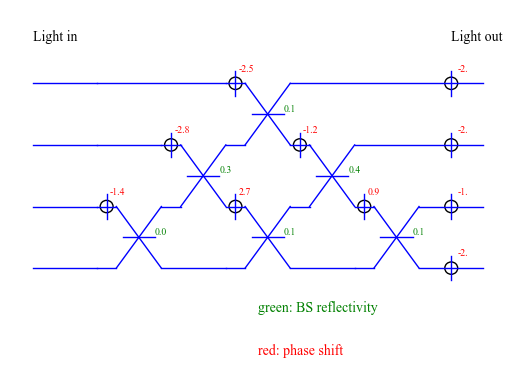

Frobenius norm: 8.521925080883833e-16


In [ ]:
U = random_unitary(10)
I = decompose_reck(U)
I.draw()

Uexp = I.calculate_transformation()

print("Frobenius norm:", np.linalg.norm(Uexp - U))

## Clements' Method
**References**

Clements, William R., et al. "Optimal design for universal multiport interferometers." Optica 3.12 (2016): 1460-1465.


Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="clements.png" width="50%"/>
</p>

As with the Reck's decomposition, we will also add a line of phase shifters at the end to achieve aritrary phase at the output (also here, the values of the phase shifters are implicitly computed by the decomposition method)

In [58]:
def decompose_clements(U):
    I = itf()
    N = int(np.sqrt(U.size))
    left_T = []
    for ii in range(N-1):
        if np.mod(ii, 2) == 0:
            for jj in range(ii+1):
                modes = [ii - jj + 1, ii + 2 - jj]
                theta = my_atan(U[N-1-jj, ii-jj], U[N-1-jj, ii-jj+1])
                phi = my_angle(U[N-1-jj, ii-jj], U[N-1-jj, ii-jj+1])
                invT = np.eye(N, dtype=np.complex128)
                invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
                invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
                invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
                invT[modes[1]-1, modes[1]-1] = np.cos(theta)
                U = np.matmul(U, invT)
                I.BS_list.append(bs(modes[0], modes[1], theta, phi))
        else:
            for jj in range(ii+1):
                modes = [N+jj-ii-1, N+jj-ii]
                theta = my_atan(U[N+jj-ii-1, jj], U[N+jj-ii-2, jj])
                phi = my_angle(-U[N+jj-ii-1, jj], U[N+jj-ii-2, jj])
                T = np.eye(N, dtype=np.complex128)
                T[modes[0]-1, modes[0]-1] = np.exp(1j * phi) * np.cos(theta)
                T[modes[0]-1, modes[1]-1] = -np.sin(theta)
                T[modes[1]-1, modes[0]-1] = np.exp(1j * phi) * np.sin(theta)
                T[modes[1]-1, modes[1]-1] = np.cos(theta)
                U = np.matmul(T, U)
                left_T.append(bs(modes[0], modes[1], theta, phi))

    for BS in np.flip(left_T, 0):
        modes = [int(BS.mode1), int(BS.mode2)]
        invT = np.eye(N, dtype=np.complex128)
        invT[modes[0]-1, modes[0]-1] = np.exp(-1j * BS.phi) * np.cos(BS.theta)
        invT[modes[0]-1, modes[1]-1] = np.exp(-1j * BS.phi) * np.sin(BS.theta)
        invT[modes[1]-1, modes[0]-1] = -np.sin(BS.theta)
        invT[modes[1]-1, modes[1]-1] = np.cos(BS.theta)
        U = np.matmul(invT, U)
        theta = my_atan(U[modes[1]-1, modes[0]-1], U[modes[1]-1, modes[1]-1])
        phi = my_angle(U[modes[1]-1, modes[0]-1], U[modes[1]-1, modes[1]-1])
        invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
        invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
        invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
        invT[modes[1]-1, modes[1]-1] = np.cos(theta)
        U = np.matmul(U, invT)
        I.BS_list.append(bs(modes[0], modes[1], theta, phi))
    phases = np.diag(U)
    I.output_phases = [np.angle(i) for i in phases]
    return I

Once we have our Clements decomposition function, we can use the interferometer $.calculate\_transformation()$ method to compute the reconstructed unitary, accounting for losses for each node

For example:

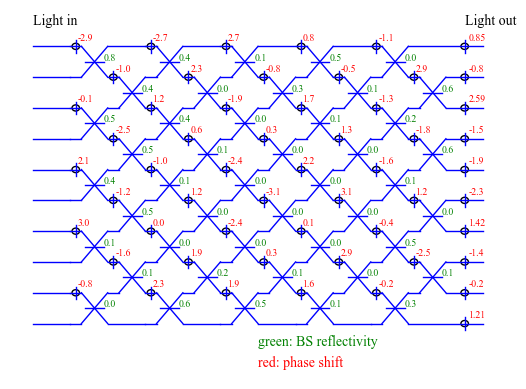

fidelity: 0.9556043954260747


In [ ]:
U = random_unitary(10)
I = decompose_clements(U)
I.draw()
Uexp = I.calculate_transformation(LN_dB=-1.5)

print("Frobenius norm:", np.linalg.norm(Uexp - U))

## Fidelity Comparison

In [60]:
def Fid(Uid, Uexp):
    return np.abs(np.trace(Uid @ Uexp.conj().T) / 
      np.sqrt(
          np.trace(Uid @ Uid.conj().T)*np.trace(Uexp @ Uexp.conj().T)
      ))**2

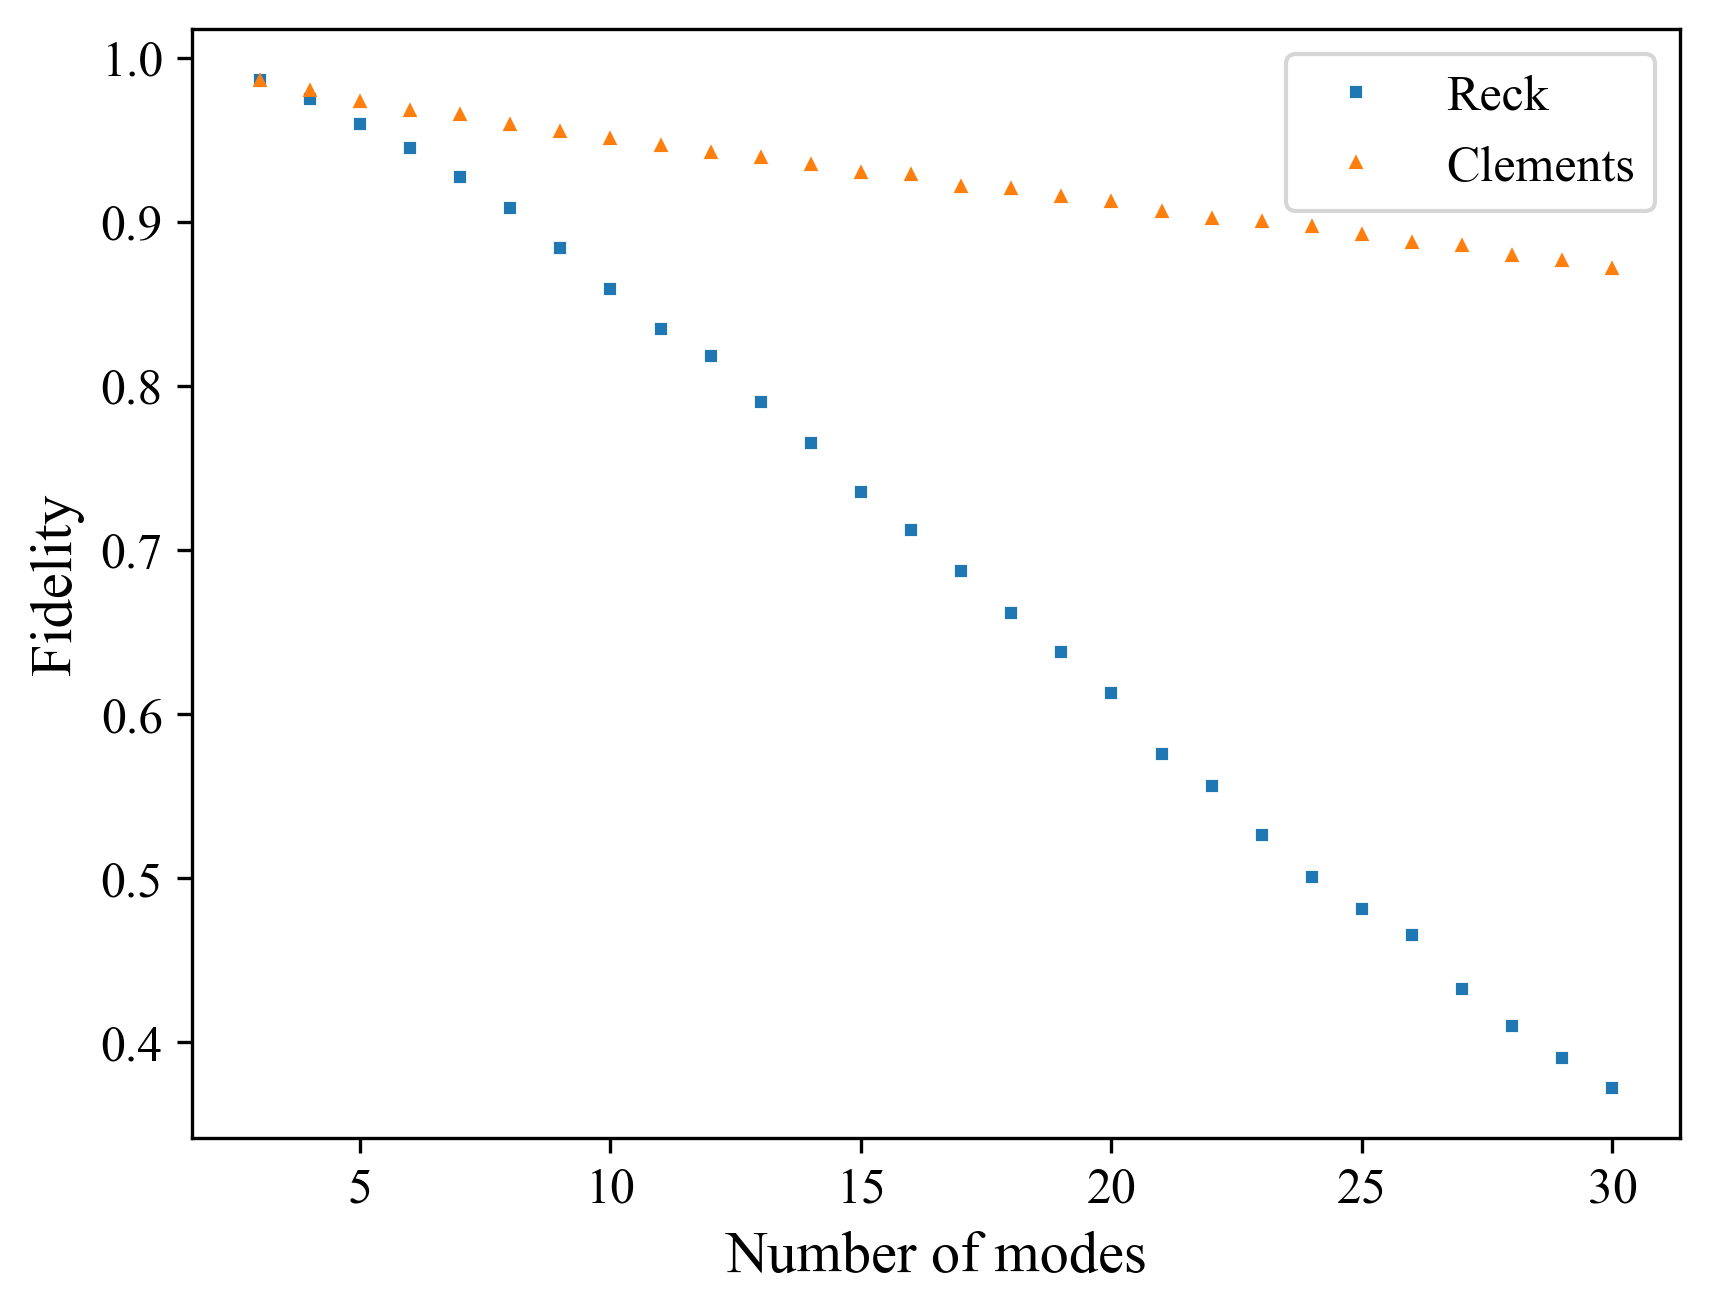

In [61]:
# System Configurations and Parameters
NUM_MODE = 31
LN_dB=-1.5
COUNT = 100

# Buffers to store the data for drawings
fidelity = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)
x = range(3, NUM_MODE)

# Sweep Parameters [Reck]
for i in range(3, NUM_MODE):
    total = 0.0
    for _ in range(COUNT):
        U = random_unitary(i)
        circuit = decompose_reck(U)
        Uexp = circuit.calculate_transformation(LN_dB=LN_dB)
        total += Fid(U, Uexp)
    fidelity[i] = total / COUNT

# Annotate Setup
y_reck = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_reck, 's', markersize=2)

# Sweep Parameters [Clements]
for i in range(3, NUM_MODE):
    total = 0.0
    for _ in range(COUNT):
        U = random_unitary(i)
        circuit = decompose_clements(U)
        Uexp = circuit.calculate_transformation(LN_dB=LN_dB)
        total += Fid(U, Uexp)
    fidelity[i] = total / COUNT

# Annotate Setup
y_clements = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_clements, '^', markersize=2)

# Decorate Figures
plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(['Reck', 'Clements'])

plt.show()